# Q3: Study the Neural Collapse phenomenon


## Setup

In [1]:
# Mount Google Drive (for saving checkpoints)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone repository
import os
if not os.path.exists('/content/OOD-Detection-Project---CSC_5IA23'):
    !git clone https://github.com/DiegoFleury/OOD-Detection-Project---CSC_5IA23/
%cd /content/OOD-Detection-Project---CSC_5IA23

Cloning into 'OOD-Detection-Project---CSC_5IA23'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 356 (delta 189), reused 266 (delta 110), pack-reused 0 (from 0)
Receiving objects: 100% (356/356), 8.73 MiB | 29.81 MiB/s, done.
Resolving deltas: 100% (189/189), done.
/content/OOD-Detection-Project---CSC_5IA23


In [3]:
# Install dependencies
!pip install -q torch torchvision matplotlib seaborn scikit-learn pyyaml imageio tqdm

In [4]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml

from src.models import ResNet18
from src.data import get_cifar100_loaders
from src.utils import Trainer, plot_training_curves, create_training_gif

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [5]:
# Load config
with open('configs/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration:")
print(yaml.dump(config, default_flow_style=False))

Configuration:
data:
  augment: true
  data_dir: ./data
  num_workers: 2
device: cuda
model:
  num_classes: 100
ood:
  datasets:
  - SVHN
  - CIFAR10
  - Textures
  sampling_ratio: 0.1
  tpt_mask:
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 0
  - 1
  - 1
  - 1
  - 1
paths:
  checkpoints: /content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints
  figures: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures
  gifs: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/gifs
  metrics: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics
  ood_detection: /content/drive/MyDrive/Colab Notebooks/OOD/Results/ood_scoring
  results: /content/drive/MyDrive/Colab Notebooks/OOD/Results
  tables: /content/drive/MyDrive/Colab Notebooks/OOD/Results/tables
training:
  batch_size: 128
  checkpoint_frequency: 25
  early_stopping_patience: 999
  epochs: 300
  lr: 0.1
  momentum: 0.9
  val_split: 0.1
  weight_decay: 0.0005



## 1. Load Data

In [6]:
print("Loading CIFAR-100 dataset...")

train_loader, val_loader, test_loader = get_cifar100_loaders(
    data_dir=config['data']['data_dir'],
    batch_size=config['training']['batch_size'],
    num_workers=config['data']['num_workers'],
    augment=config['data']['augment'],
    val_split=config['training']['val_split']
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading CIFAR-100 dataset...


100%|██████████| 169M/169M [00:02<00:00, 73.7MB/s]


Train batches: 352
Val batches: 40
Test batches: 79


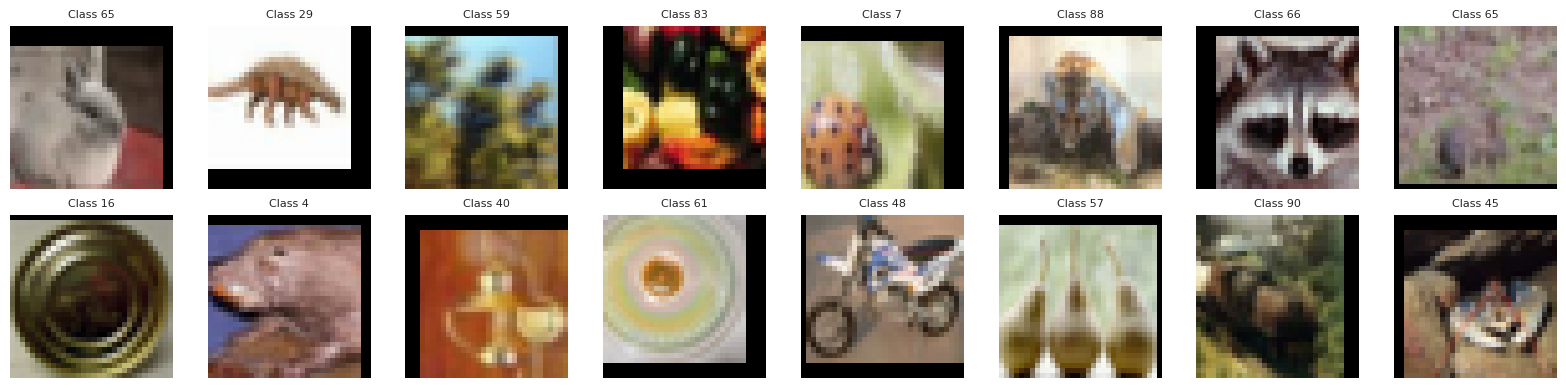

In [7]:
# Visualize sample batch
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()
    # Denormalize
    img = img * np.array([0.2675, 0.2565, 0.2761]) + np.array([0.5071, 0.4867, 0.4408])
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Class {labels[i].item()}", fontsize=8)

plt.tight_layout()

sample_batch_path = os.path.join(config['paths']['figures'], 'training', 'sample_batch.png')
plt.savefig(sample_batch_path, dpi=150, bbox_inches='tight')
plt.show()

## 2. Create Model

In [8]:
print("Creating ResNet-18 model...")

model = ResNet18(num_classes=config['model']['num_classes'])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
x_test = torch.randn(2, 3, 32, 32)
with torch.no_grad():
    out = model(x_test)
print(f"Output shape: {out.shape}")

Creating ResNet-18 model...
Total parameters: 11,220,132
Trainable parameters: 11,220,132
Output shape: torch.Size([2, 100])


## 3. Train Model

In [9]:
# 3. Train or resume from checkpoint
import glob
import re
import os

checkpoint_dir = config['paths']['checkpoints']
print(checkpoint_dir)
checkpoints = glob.glob(os.path.join(checkpoint_dir, 'resnet18_cifar100_*.pth'))
print(checkpoints)
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=config['training']['lr'],
    momentum=config['training']['momentum'],
    weight_decay=config['training']['weight_decay'],
    device=device
)

if checkpoints:
    # Extract epoch number from checkpoint filename
    def get_epoch_num(path):
        match = re.search(r'epoch(\d+)', path)
        if match:
            return int(match.group(1))
        return 0

    # Get checkpoint with highest epoch number
    latest = max(checkpoints, key=get_epoch_num)
    epoch_num = get_epoch_num(latest)

    print(f"Resuming from: {os.path.basename(latest)} (epoch {epoch_num})")
    trainer.load_checkpoint(latest)

    epochs_done = len(trainer.history.get('train_loss', []))
    epochs_left = max(0, config['training']['epochs'] - epochs_done)
    print(f"Epoch {epochs_done}/{config['training']['epochs']} | Best val: {trainer.best_val_acc:.2f}%")
else:
    print("Starting fresh training")
    epochs_left = config['training']['epochs']

if epochs_left > 0:
    history = trainer.train(
        epochs=epochs_left,
        save_dir=checkpoint_dir,
        early_stopping_patience=config['training']['early_stopping_patience'],
        checkpoint_frequency=config['training']['checkpoint_frequency']
    )
else:
    print("Already trained!")
    history = trainer.history

print("\n" + "="*50)
print("Training finished!")
print("="*50)


/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints
['/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_best.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch175.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch25.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch50.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch75.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch100.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch125.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch150.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch200.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resnet18_cifar100_epoch225.pth', '/content/drive/MyDrive/Colab Notebooks/OOD/Checkpoints/resne

NC analysis module imported.
Checkpoints found: 13
   - resnet18_cifar100_best.pth
   - resnet18_cifar100_epoch100.pth
   - resnet18_cifar100_epoch125.pth
   - resnet18_cifar100_epoch150.pth
   - resnet18_cifar100_epoch175.pth
   ... and 8 more
Running Neural Collapse analysis...
   Device: cuda
   Classes: 100



Analyzing checkpoints:   8%|▊         | 1/13 [00:55<11:07, 55.63s/it]

  Epoch    0 | Acc 0.9998 | NC1 0.1404 | NC3 0.0387 | NC4 0.0001


Analyzing checkpoints:  15%|█▌        | 2/13 [01:49<10:03, 54.87s/it]

  Epoch   25 | Acc 0.5544 | NC1 5.2223 | NC3 0.4301 | NC4 0.3781


Analyzing checkpoints:  23%|██▎       | 3/13 [02:41<08:53, 53.36s/it]

  Epoch   50 | Acc 0.6733 | NC1 3.5528 | NC3 0.4073 | NC4 0.2820


Analyzing checkpoints:  31%|███       | 4/13 [03:33<07:56, 52.99s/it]

  Epoch   75 | Acc 0.6858 | NC1 3.2498 | NC3 0.3576 | NC4 0.2598


Analyzing checkpoints:  38%|███▊      | 5/13 [04:27<07:05, 53.25s/it]

  Epoch  100 | Acc 0.7525 | NC1 2.5501 | NC3 0.3009 | NC4 0.2066


Analyzing checkpoints:  46%|████▌     | 6/13 [05:18<06:07, 52.51s/it]

  Epoch  125 | Acc 0.7952 | NC1 2.2842 | NC3 0.2919 | NC4 0.1739


Analyzing checkpoints:  54%|█████▍    | 7/13 [06:11<05:15, 52.57s/it]

  Epoch  150 | Acc 0.8285 | NC1 2.0285 | NC3 0.2602 | NC4 0.1480


Analyzing checkpoints:  62%|██████▏   | 8/13 [07:06<04:26, 53.35s/it]

  Epoch  175 | Acc 0.8628 | NC1 1.6521 | NC3 0.2201 | NC4 0.1162


Analyzing checkpoints:  69%|██████▉   | 9/13 [08:01<03:35, 53.92s/it]

  Epoch  200 | Acc 0.9456 | NC1 1.1489 | NC3 0.1535 | NC4 0.0431


Analyzing checkpoints:  77%|███████▋  | 10/13 [08:56<02:42, 54.11s/it]

  Epoch  225 | Acc 0.9920 | NC1 0.6635 | NC3 0.0880 | NC4 0.0054


Analyzing checkpoints:  85%|████████▍ | 11/13 [09:52<01:49, 54.69s/it]

  Epoch  250 | Acc 0.9997 | NC1 0.2173 | NC3 0.0441 | NC4 0.0001


Analyzing checkpoints:  92%|█████████▏| 12/13 [10:50<00:55, 55.67s/it]

  Epoch  275 | Acc 0.9998 | NC1 0.1463 | NC3 0.0389 | NC4 0.0000


Analyzing checkpoints: 100%|██████████| 13/13 [11:43<00:00, 54.11s/it]

  Epoch  300 | Acc 0.9998 | NC1 0.1357 | NC3 0.0374 | NC4 0.0000

NEURAL COLLAPSE METRICS SUMMARY
Epochs analyzed: 13
Epoch range: 0 → 300
Final accuracy: 0.9998
Final NC1 Tr[Σ_W Σ_B† / C]: 0.1357
Final NC2 equinorm (M CoV): 0.0340
Final NC2 equiangularity (cos M): 0.0587
Final NC3 (W-M dist): 0.0374
Final NC4 (NCC mismatch): 0.0000


 Saved: /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/neural_collapse/nc_evolution_all.png


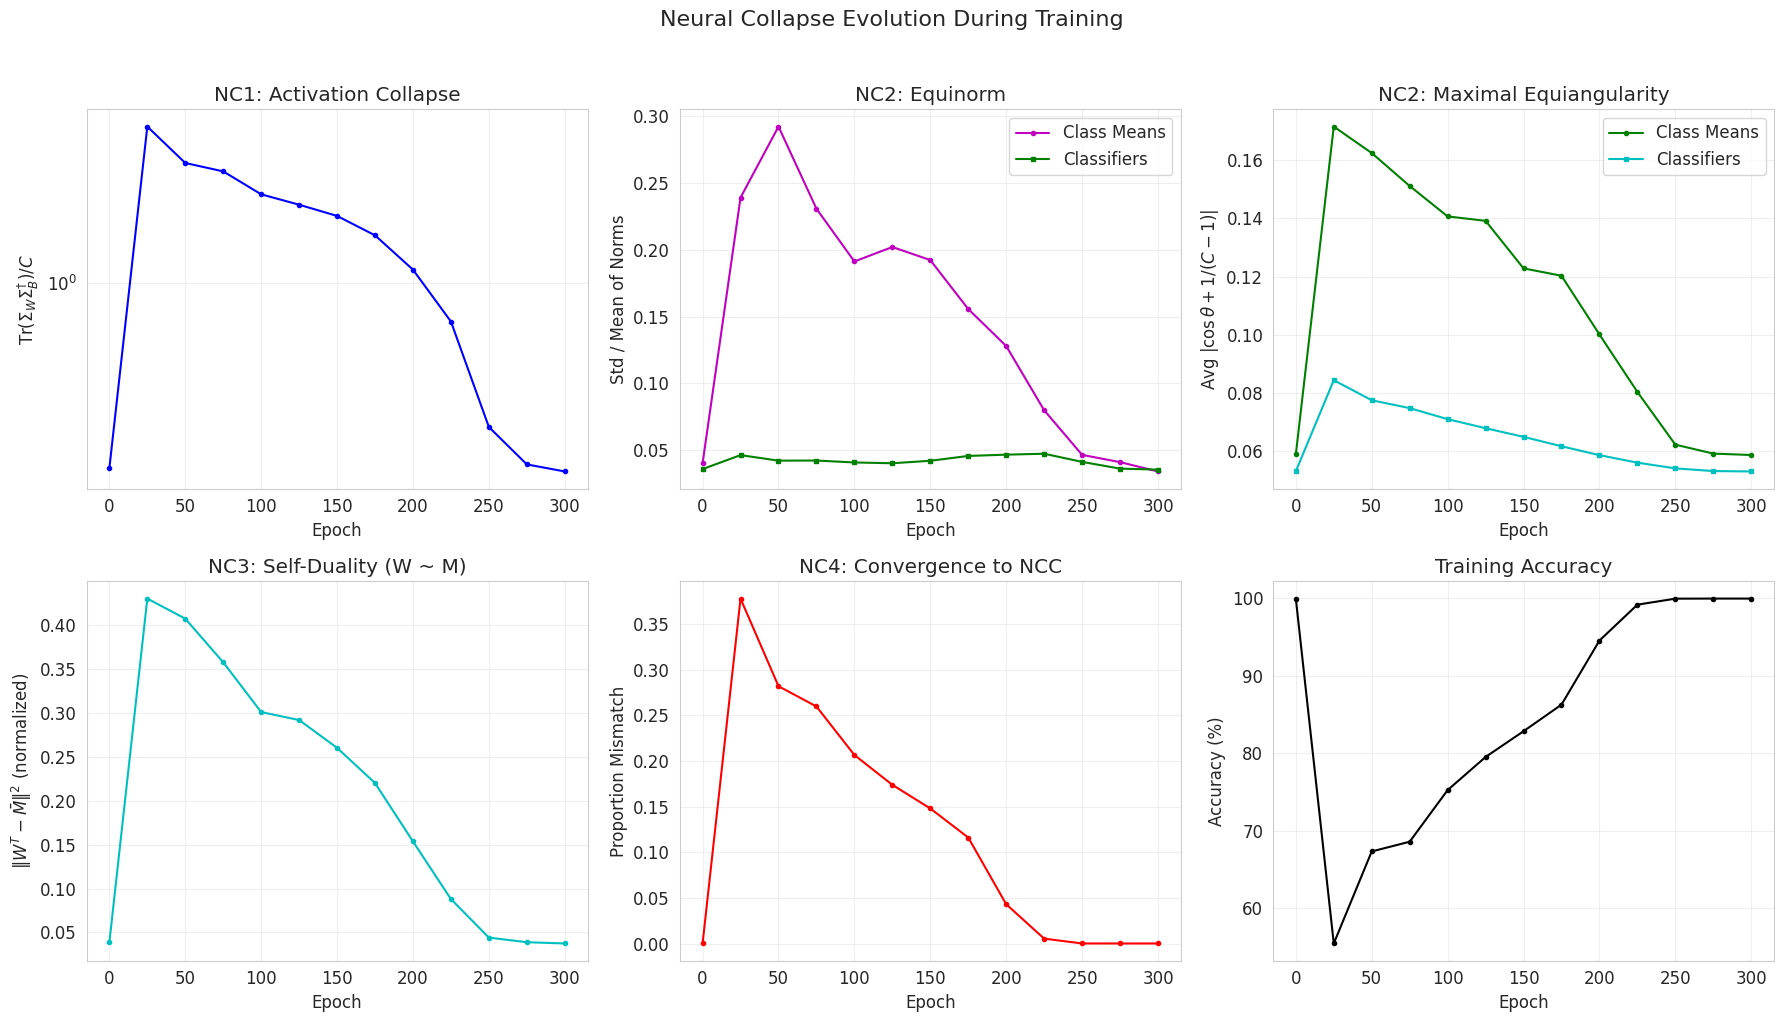

 Saved 5 individual figures to /content/drive/MyDrive/Colab Notebooks/OOD/Results/figures/neural_collapse
5 individual figures generated
 Metrics saved to: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/nc_evolution_metrics.yaml
Metrics saved to JSON: /content/drive/MyDrive/Colab Notebooks/OOD/Results/metrics/nc_evolution_metrics.json

NEURAL COLLAPSE PHASE ANALYSIS

Terminal Phase detected at epoch 0
   (accuracy > 99%)

NC metrics at the start of the Terminal Phase:
   NC1 (Sw/Sb): 0.1404
   NC3 (W~=M):  0.0387
   NC4 (NCC):   0.0001

NC metrics at the end of training:
   NC1 (Sw/Sb): 0.1357
   NC3 (W~=M):  0.0374
   NC4 (NCC):   0.0000

NC1 reduction: 3.3%



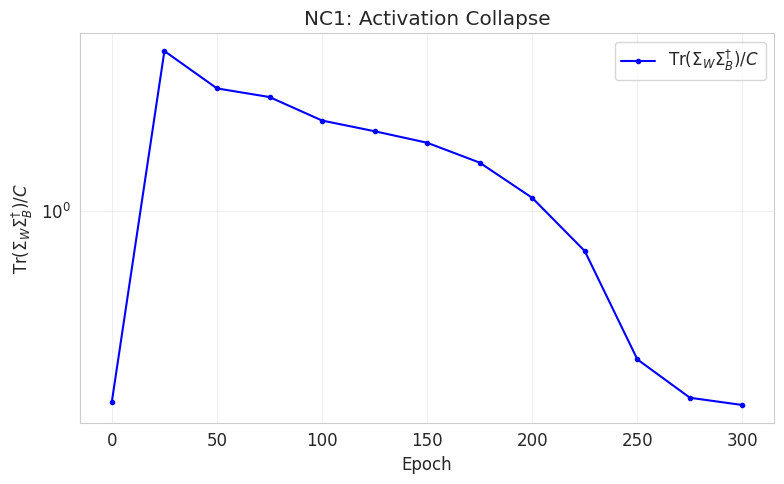

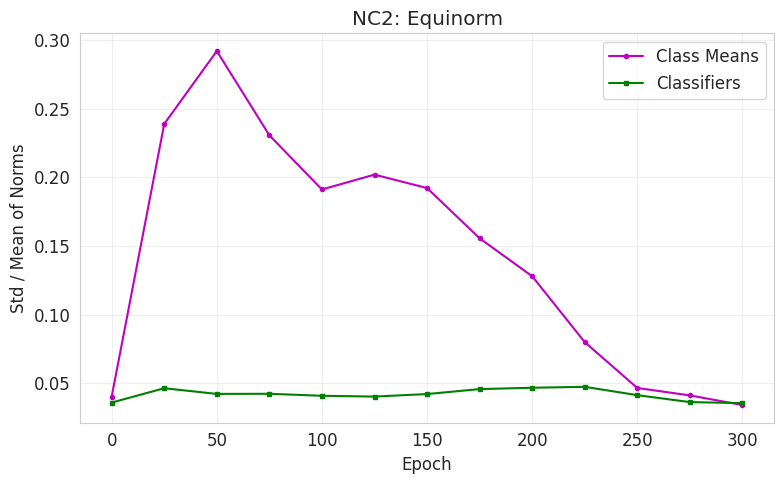

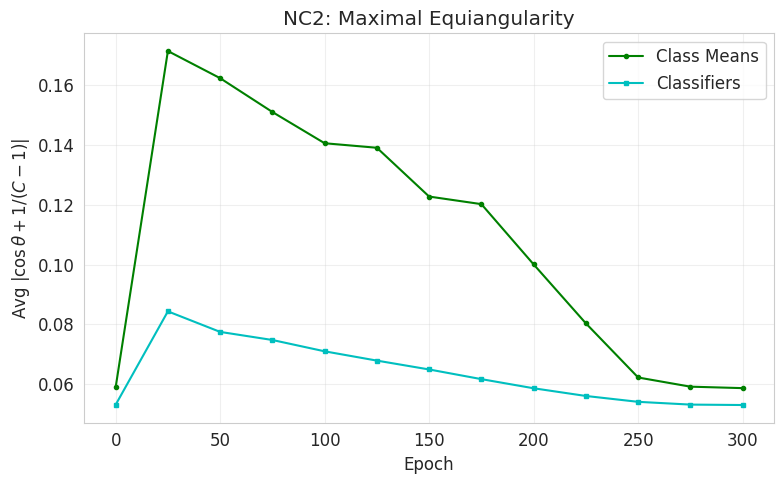

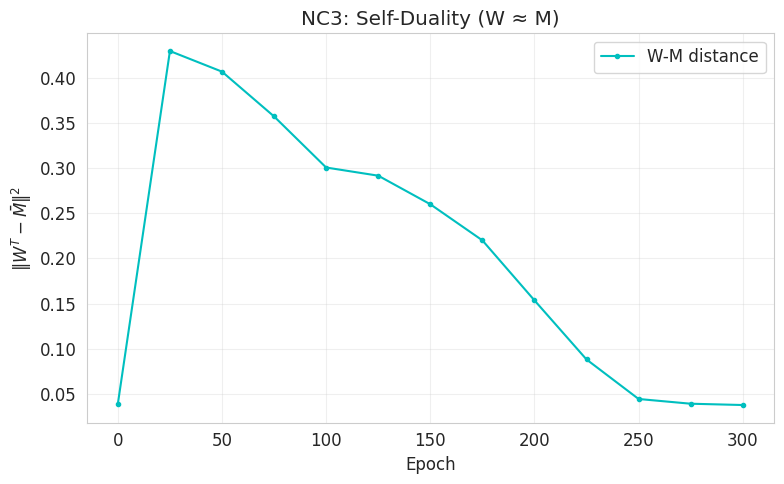

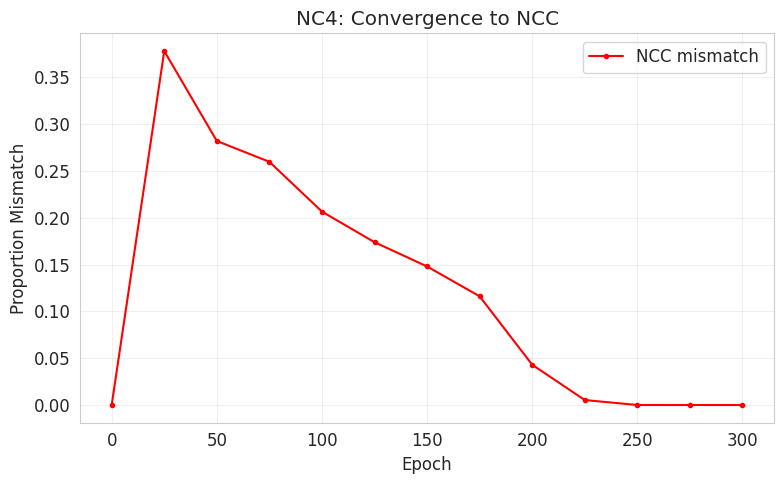

In [10]:
import sys
import os

from src.neural_collapse.nc_analysis import (
    load_checkpoints_and_analyze,
    plot_nc_evolution,
    plot_nc_individual,
    save_metrics_yaml,
    NCMetricsTracker
)


print("NC analysis module imported.")

checkpoint_dir = config['paths']['checkpoints']
figures_dir = os.path.join(config['paths']['figures'], 'neural_collapse')
metrics_dir = config['paths']['metrics']

import glob
checkpoints = glob.glob(os.path.join(checkpoint_dir, 'resnet18_cifar100_*.pth'))
print(f"Checkpoints found: {len(checkpoints)}")
for ckpt in sorted(checkpoints)[:5]:
    print(f"   - {os.path.basename(ckpt)}")
if len(checkpoints) > 5:
    print(f"   ... and {len(checkpoints) - 5} more")

print("Running Neural Collapse analysis...")
print(f"   Device: {device}")
print(f"   Classes: {config['model']['num_classes']}")
print()


tracker = load_checkpoints_and_analyze(
    checkpoint_dir=checkpoint_dir,
    model_class=ResNet18,
    loader=train_loader,
    device=device,
    num_classes=config['model']['num_classes'],
    checkpoint_pattern='resnet18_cifar100_*.pth',
    epoch_regex=r'epoch(\d+)',
    verbose=True
)

print("\n" + tracker.summary())

os.makedirs(figures_dir, exist_ok=True)

fig = plot_nc_evolution(tracker, save_dir=figures_dir)
plt.show()

individual_figs = plot_nc_individual(tracker, save_dir=figures_dir)
print(f"{len(individual_figs)} individual figures generated")

os.makedirs(metrics_dir, exist_ok=True)

yaml_path = os.path.join(metrics_dir, 'nc_evolution_metrics.yaml')
save_metrics_yaml(tracker, yaml_path)

# Also save as JSON
import json
json_path = os.path.join(metrics_dir, 'nc_evolution_metrics.json')
metrics_dict = tracker.to_dict()

# Convert NaN to None (JSON does not support NaN)
for key, values in metrics_dict.items():
    if isinstance(values, list):
        metrics_dict[key] = [
            v if not (isinstance(v, float) and np.isnan(v)) else None
            for v in values
        ]

with open(json_path, 'w') as f:
    json.dump(metrics_dict, f, indent=2)
print(f"Metrics saved to JSON: {json_path}")


print("\n" + "="*60)
print("NEURAL COLLAPSE PHASE ANALYSIS")
print("="*60)

# Find when accuracy > 99%
terminal_phase_idx = None
for i, acc in enumerate(tracker.accuracy):
    if acc > 0.99:
        terminal_phase_idx = i
        break

if terminal_phase_idx is not None:
    print(f"\nTerminal Phase detected at epoch {tracker.epochs[terminal_phase_idx]}")
    print(f"   (accuracy > 99%)")
    print()
    print("NC metrics at the start of the Terminal Phase:")
    print(f"   NC1 (Sw/Sb): {tracker.Sw_invSb[terminal_phase_idx]:.4f}")
    print(f"   NC3 (W~=M):  {tracker.W_M_dist[terminal_phase_idx]:.4f}")
    print(f"   NC4 (NCC):   {tracker.NCC_mismatch[terminal_phase_idx]:.4f}")
    print()
    print("NC metrics at the end of training:")
    print(f"   NC1 (Sw/Sb): {tracker.Sw_invSb[-1]:.4f}")
    print(f"   NC3 (W~=M):  {tracker.W_M_dist[-1]:.4f}")
    print(f"   NC4 (NCC):   {tracker.NCC_mismatch[-1]:.4f}")

    # Compute reduction
    if not np.isnan(tracker.Sw_invSb[terminal_phase_idx]) and not np.isnan(tracker.Sw_invSb[-1]):
        nc1_reduction = (tracker.Sw_invSb[terminal_phase_idx] - tracker.Sw_invSb[-1]) / tracker.Sw_invSb[terminal_phase_idx] * 100
        print(f"\nNC1 reduction: {nc1_reduction:.1f}%")
else:
    print("\nTerminal Phase not detected (accuracy never exceeded 99%)")
    print("   The model may need more training epochs.")

print("\n" + "="*60)